In [1]:
%matplotlib inline
import h5py

import matplotlib.pyplot as plt
import matplotlib.gridspec as mgrid


import numpy as np
import pandas as pd
from activ import TrackTBIFile
from activ.viz import get_nmf_colors, get_nmf_labels, get_embeddings, get_nmf_feature_types
from activ.nmf.viz import weights_pie_scatter
# from activ.cca.viz import cross_decomp_scatter
import matplotlib.colors as mpc
from activ.paper import plot_cat2cont


/Users/ajtritt/anaconda/envs/activ_37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/ajtritt/anaconda/envs/activ_37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.coordinate_descent module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/ajtritt/anaconda/envs/activ_37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: 

1. Conceptual figure for CCA
2. Cumulative outcome variance explained as a function of sorted CVs
3. Scatter plots for first CV
4. scatter plot for second CV
5. Horizontal barplots. Mirror current orientations across vertical axis
6. Heatmap


In [2]:
CONCEPTUAL_PATH = "../../paper/cross-decomposition-paper.png"
ALL_CVS_PATH = "tracktbi.cca.all_cvs.h5"
NMFS_PATH = "../NMF/tracktbi.reg_nmf.h5"

# Conceptual Figure

In [3]:
def add_border(img, size=10):
    sh = img.shape
    new_sh = (sh[0] + 2*size, sh[1] + 2*size, sh[2])
    ret = np.zeros(new_sh)
    ret[size:-size, size:-size, :] = img
    return ret

def display_img(path, ax=None, border=10):
    if ax is None:
        ax = plt.gca()
    img = plt.imread(path)
    if border is not None:
        img = add_border(img, size=10)
    ax.imshow(img)
    ax.axis('off')

# Cumulative Explained Variance

In [45]:
from activ.cca.utils import compute_explained_variance

def get_exp_var(path):
    tbifile = TrackTBIFile(path)
    cv_bm = tbifile.cca.bm
    cv_oc = tbifile.cca.oc
    exp_var, n_comp = compute_explained_variance(cv_bm, cv_oc, tbifile.outcomes, perc_var=1.0, method='cos')
    return exp_var

def plot_exp_var(exp_var, ylabel=None, ax=None, fontsize=12, color='black'):
    if ax is None:
        ax = plt.gca()
    if isinstance(exp_var, str):
        exp_var = get_exp_var(path)
    ax.plot(exp_var, color=color)
    ax.set_xlabel('Canonical variate', fontsize=fontsize)
    #ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params('both', labelsize=fontsize)
    
def plot_cum_exp_var(exp_var, ylabel=None, ax=None, fontsize=12, color='red'):
    if ax is None:
        ax = plt.gca()
    if isinstance(exp_var, str):
        exp_var = get_exp_var(path)
    cum = np.sort(exp_var)[::-1].cumsum()
    ax.plot(cum, color=color)
    ax.set_xlabel('Canonical variate', fontsize=fontsize)
    #ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params('both', labelsize=fontsize)
    #ax.axhline(0.95, ls=':', color='k')
    ytick = [0.0, 0.9]
    ax.set_yticks(ytick)
    ax.set_yticklabels(ytick)

In [5]:
exp_var = get_exp_var(ALL_CVS_PATH)

# Weights Heatmap

In [65]:
def weights_heatmap_helper(weights, label, ax=None):
    mat = weights.T
    vmax = np.abs(mat).max()
    vmin = -1 * vmax

    if ax is None: ax = plt.gca()

    im = ax.imshow(mat, aspect='auto', interpolation='none', cmap='RdGy', vmin=vmin, vmax=vmax)

#     cbar_ax = ax.figure.colorbar(im, ax=ax).ax
#     cbar_ax.tick_params('y', labelsize=12)

    ax.tick_params('both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax.set_ylabel('canonical variate', fontsize=20)
    ax.set_xlabel(label, fontsize=20)
    
def weights_heatmap(path, ax_bm, ax_oc, n_cvs=None):    
    tbifile = TrackTBIFile(path)
    bm_weights = tbifile.cca.bm_bases
    oc_weights = tbifile.cca.oc_bases
    print(bm_weights.shape, oc_weights.shape)
    if n_cvs is not None:
        bm_weights = bm_weights[:, :n_cvs]
        oc_weights = oc_weights[:, :n_cvs]
    weights_heatmap_helper(bm_weights, 'biomarkers', ax=ax_bm)
    weights_heatmap_helper(oc_weights, 'outcomes', ax=ax_oc)

# Barplots

In [7]:
from activ.viz import get_nmf_colors, get_nmf_labels, get_embeddings, get_nmf_feature_types

def add_loadings(dd_df, loadings):
    """
    Args:
        dd_df (pd.DataFrame)    : DataFrame of the variable class
        loadings (array)        : shape = (n_features, n_cvs)
    """
    dd_df = dd_df.copy()
    for i in range(loadings.shape[1]):
        dd_df[str(i+1)] = loadings[:, i]
    return dd_df


def get_key(labels):
    def key(x):
        return pd.Series(index=labels, data=np.arange(len(labels))).filter(x).values
    return key


def get_domain_weight(df, ddict, coef, domain=True, subdomain=True, scale=False):
    """

    Args:
        scale: scale weights by the number of variables in the domain
    """
    weights = np.abs(coef[coef != 0])
    weights /= weights.sum()
    sub_data_dict = ddict.filter(items=df.columns[coef != 0], axis=0)
    dweight = dict()
    for d in np.unique(sub_data_dict):
        mask = (sub_data_dict == d).values.flatten()
        if scale:
            dweight[d] = weights[mask].mean()
        else:
            dweight[d] = weights[mask].sum()
    s = pd.Series(data = dweight)
    s /= s.sum()
    return s

In [47]:
################################################################################################################################################

def plot_grouped_barplot(cca_path, nmf_path, ax_bm=None, ax_oc=None, fontsize=12, n_cvs=None):
    
    if ax_bm is None or ax_oc is None:
        fig, (ax_bm, ax_oc) = plt.subplots(1, 2, figsize=(10, 5))

    tbifile = TrackTBIFile('tracktbi.cca.all_cvs.h5')
    gcs_simple = tbifile.biomarkers[:, np.where(tbifile.biomarker_features == 'GCSMildModSevereRecode')[0][0]]
    
    bm_cv = tbifile.cca.bm
    oc_cv = tbifile.cca.oc
    
    bm_loadings = tbifile.cca.bm_bases
    oc_loadings = tbifile.cca.oc_bases
    
    if n_cvs is not None:
        bm_cv = bm_cv[:, :n_cvs]
        oc_cv = oc_cv[:, :n_cvs]
        bm_loadings = bm_loadings[:, :n_cvs]
        oc_loadings = oc_loadings[:, :n_cvs]
    
    bm_colors, oc_colors = get_nmf_colors()
    bm_bases_labels, oc_bases_labels = get_nmf_labels()

    nmf_tbifile = TrackTBIFile(nmf_path)
    datadict_df = get_nmf_feature_types(nmf_tbifile)
    
    bm_df = nmf_tbifile.biomarker_df()
    oc_df = nmf_tbifile.outcome_df()

    bm_nmf = nmf_tbifile.nmf.bm
    oc_nmf = nmf_tbifile.nmf.oc


################################################################################################################################################

    x_dweights = list()
    y_dweights = list()
    scale = True

    for i in range(oc_loadings.shape[1]):
        x_dweight = get_domain_weight(bm_df, datadict_df, bm_loadings[:, i], scale=scale)
        y_dweight = get_domain_weight(oc_df, datadict_df, oc_loadings[:, i], scale=scale)
        x_dweight.name = '' #'CV-%d predictors' % (i+1)
        y_dweight.name = '' #'CV-%d outcomes' % (i+1)
        x_dweights.append(x_dweight.to_dict())
        y_dweights.append(y_dweight.to_dict())

    x_dweights = pd.DataFrame(data=x_dweights).fillna(0)
    y_dweights = pd.DataFrame(data=y_dweights).fillna(0)

################################################################################################################################################

    bm_pal_lut = dict(zip(bm_bases_labels, bm_colors))
    oc_pal_lut = dict(zip(oc_bases_labels, oc_colors))

    oc_df_ord = add_loadings(datadict_df.filter(oc_df.columns, axis=0), oc_loadings).sort_values(by=0, key=get_key(oc_bases_labels))
    bm_df_ord = add_loadings(datadict_df.filter(bm_df.columns, axis=0), bm_loadings).sort_values(by=0, key=get_key(bm_bases_labels))


    
    x_dweights.plot.barh(ax=ax_bm, legend=False, color=dict(zip(bm_bases_labels, bm_colors)))
    
    y_dweights.iloc[::-1].plot.barh(ax=ax_oc, legend=False, color=dict(zip(oc_bases_labels, oc_colors)))

    ax = ax_bm
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.invert_xaxis()  # labels read top-to-bottom
    ax.set_yticks([])

    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())

    ax2.set_yticks([])
    ax_oc.set_yticks([])
    ax2.set_yticklabels([])
    ax_oc.set_yticklabels([])
    
    ax_bm.tick_params('both', labelsize=fontsize)
    ax_oc.tick_params('both', labelsize=fontsize)
    
    ticks = [0.0, 0.1, 0.2]
    for ax in (ax_bm, ax_oc):
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)

In [33]:
from activ.cca.viz import cross_decomp_scatter

def plot_scatters(path, axes=None, n_cvs=2, fontsize=16, **kwargs):

    if axes is None:
        fig, axes = plt.subplots(1, n_cvs, figsize=(5*n_cvs, 5))

    tbifile = TrackTBIFile(path)
    cv_bm = tbifile.cca.bm
    cv_oc = tbifile.cca.oc
    gcs_simple = tbifile.biomarkers[:, np.where(tbifile.biomarker_features == 'GCSMildModSevereRecode')[0][0]]
    
    gcs_hurd = np.zeros(len(gcs_simple), dtype='U8')
    gcs_hurd[gcs_simple == 0.0] = 'Mild'
    gcs_hurd[gcs_simple == 1.0] = 'Moderate'
    gcs_hurd[gcs_simple == 2.0] = 'Severe'
    
    for i in range(n_cvs):
        x = cv_bm[:, i]
        y = cv_oc[:, i]
        cross_decomp_scatter(x, y, fontsize=fontsize, labels=gcs_hurd, ax=axes[i], legend_fontsize=fontsize, **kwargs)

In [38]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from activ.viz import get_labels

def _check_array(v):
    if isinstance(v, pd.Series):
        v = v.values
    if len(v.shape) == 1:
        v = v.reshape(v.shape[0], 1)
    elif len(v.shape) == 2:
        if v.shape[1] != 1:
            raise ValueError('v must be 1D: shape = %s' % str(v.shape))
        v = v.reshape(v.shape[0])
    return v
def cross_decomp_scatter(x, y, regressor=LinearRegression(), labels=None, fitline=True,
                         solid_points=False, markeredgewidth=1, markersize=None,
                         fontsize=16, legend_fontsize=None,
                         title=None, xlabel=None, ylabel=None, legend_title=None, ax=None):
    """
    Args:
        x:                  the independent variable to plot
        y:                  the dependent variable to plot
        regressor:          the scikit-learn regressor object to use draw a line-fit
        labels:             category labels to apply
        solid_points:       plot solid points instead of circles
        markeredgewidth:    the edge widgth of markers
        markeredgesize:     the size of markers
        title:              the title to add to the plot
        xlabel:             the label to add to the X-axis
        ylabel:             the label to add to the Y-axis
        legend_title:       the title to give to the legend
        ax:                 the matplotlib Axes object draw the plot on
    """
    if ax is None:
        import matplotlib.pyplot as plt
        ax = plt.gca()

    _x = _check_array(x)
    _y = _check_array(y)

    colors, patches = None, None
    mk_kwargs = dict(marker='o', color='none')
    scatter_kwargs = dict()

    if solid_points:
        markersize = markersize or 5
        scatter_kwargs['c'] = colors
        colors_key = 'c'
    else:
        markersize = markersize or 9
        mk_kwargs['markerfacecolor'] = 'none'
        mk_kwargs['markeredgewidth'] = markeredgewidth or 1
        colors_key = 'edgecolors'
        scatter_kwargs['facecolors'] = 'none'
        scatter_kwargs['linewidths'] = mk_kwargs['markeredgewidth']

    mk_kwargs = dict(marker='o', color='none')
    scatter_kwargs = dict()

    if solid_points:
        markersize = markersize or 5
        scatter_kwargs['c'] = colors
        colors_key = 'c'
    else:
        markersize = markersize or 9
        mk_kwargs['markerfacecolor'] = 'none'
        mk_kwargs['markeredgewidth'] = markeredgewidth or 1
        colors_key = 'edgecolors'
        scatter_kwargs['facecolors'] = 'none'
        scatter_kwargs['linewidths'] = mk_kwargs['markeredgewidth']

    mk_kwargs['markersize'] = markersize
    scatter_kwargs['s'] = markersize**2


    if labels is not None:
        colors, patches = get_labels(labels, solid_points=solid_points, marker_kwargs=mk_kwargs)
    else:
        colors = ['black'] * _x.shape[0]

    scatter_kwargs[colors_key] = colors

    ax.scatter(_x, _y, **scatter_kwargs)

    if legend_fontsize is None:
        legend_fontsize = fontsize-4

    if patches is not None:
        print("legend_fontsize", legend_fontsize)
        ax.legend(handles=patches, title=legend_title, loc=2, fontsize=legend_fontsize)

    ax.tick_params('both', labelsize=fontsize)

    if title is not None:
        ax.set_title(title, fontsize=fontsize)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=fontsize)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=fontsize)

    if fitline:
        y_pred = cross_val_predict(regressor, _x, _y, cv=5)
        cv_r2 = r2_score(_y, y_pred)

        regressor.fit(_x, _y)
        # raw_r2 = r2_score(_y, regressor.predict(_x))

        xfit = np.linspace(min(_x),max(_x), 1000).reshape((1000,1))
        yfit = regressor.predict(xfit)
        
        ax.plot(xfit, yfit, color='black')
        x_pos, y_pos = (0.5, 0.1)
        ax.text(x_pos, y_pos, "$R^2$ = %0.4f" % cv_r2, size=fontsize, transform=ax.transAxes)
    return ax

legend_fontsize 16
legend_fontsize 16
(235, 177) (177, 177)


/Users/ajtritt/anaconda/envs/activ_37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:321: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/Users/ajtritt/anaconda/envs/activ_37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


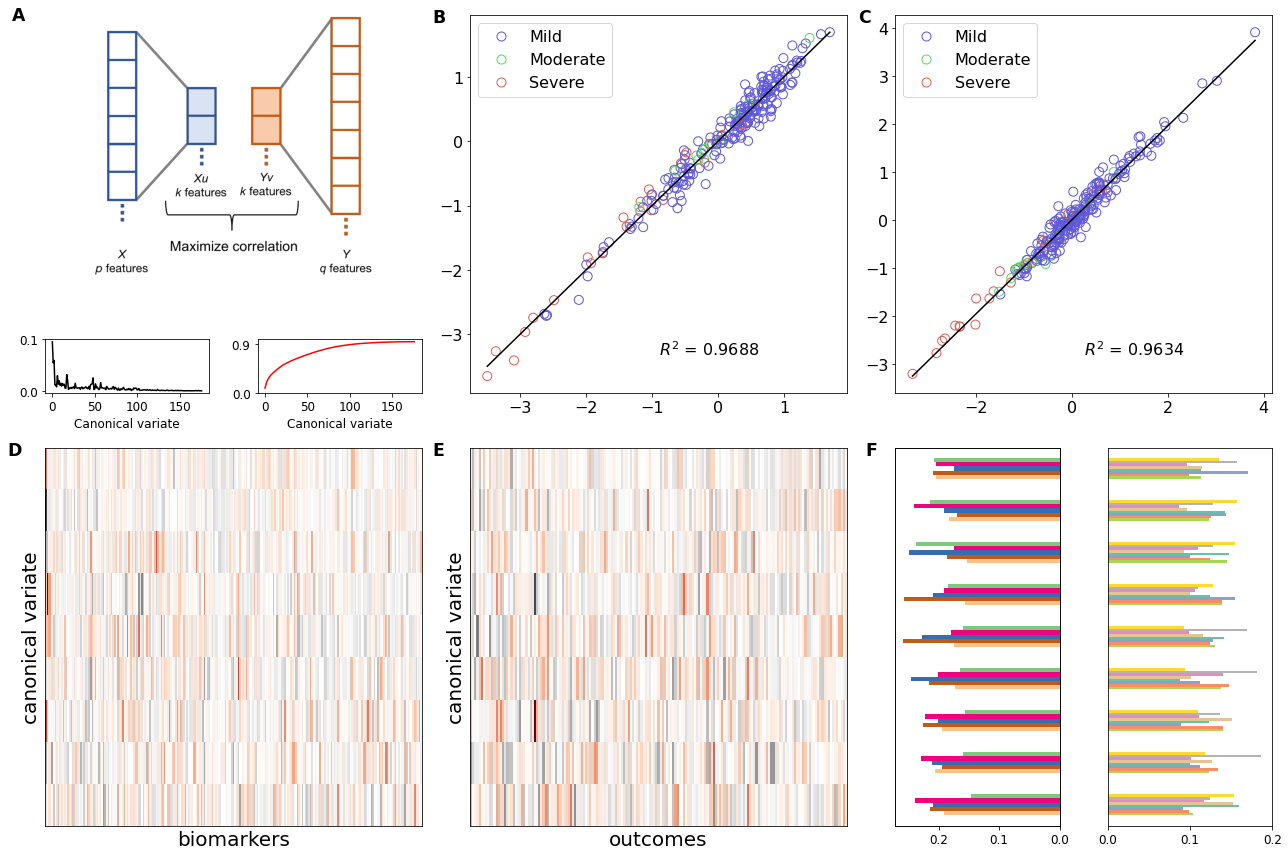

In [66]:
#fig = plt.figure(figsize=(12, 8), tight_layout=True)
fig = plt.figure(figsize=(18, 12), tight_layout=True)

q_x = 1
half_x = 2*q_x
x = 2 * half_x
gs = mgrid.GridSpec(nrows=2*x, ncols=3*x)

# Conceptual figure
ax_Concept = fig.add_subplot(gs[0:3*q_x, 0:x])
display_img(CONCEPTUAL_PATH, ax_Concept, border=5)

# Cumulative Explained Varianc
ax_ExpVar = fig.add_subplot(gs[3*q_x:x, 0:half_x])
ax_CumVar = fig.add_subplot(gs[3*q_x:x, half_x:x])
plot_exp_var(exp_var, ax=ax_ExpVar)
plot_cum_exp_var(exp_var, ax=ax_CumVar)

# Scatters
ax_Scatter = list()
ax_Scatter.append(fig.add_subplot(gs[:x, x:2*x]))
ax_Scatter.append(fig.add_subplot(gs[:x, 2*x:]))
plot_scatters(ALL_CVS_PATH, axes=ax_Scatter)


# Heatmaps
ax_BMHeatmap = fig.add_subplot(gs[x:, :x])
ax_OCHeatmap = fig.add_subplot(gs[x:, x:2*x])
weights_heatmap(ALL_CVS_PATH, ax_BMHeatmap, ax_OCHeatmap, n_cvs=9)


# Barplots
ax_BMBars = fig.add_subplot(gs[x:, 2*x:5*half_x])
ax_OCBars = fig.add_subplot(gs[x:, 5*half_x:])
plot_grouped_barplot(ALL_CVS_PATH, NMFS_PATH, ax_bm=ax_BMBars, ax_oc=ax_OCBars, n_cvs=9)

def add_label(ax, label, x=-0.1, y=0.98 ):
    ax.text(x, y, label,  weight='bold', transform=ax.transAxes, size='xx-large')   
    
add_label(ax_Concept, "A", x=-0.25)
add_label(ax_BMBars, "F", x=-0.18)
for ax, lbl in zip([ax_Scatter[0], ax_Scatter[1], ax_BMHeatmap, ax_OCHeatmap], "BCDE"):
    add_label(ax, lbl)
    

plt.savefig('../../paper/MultiPanel_cca.png', dpi=100)